Задача : **Сентиментальный анализ текста** — это классификация по эмоциональной
окраске: положительной, нейтральной или негативной. Такой подход помогает, например, понимать, как пользователи оценивают товар по их отзывам.

# Часть 1. Первичный анализ данных и тематическое моделирование

In [ ]:
#импорт и установка необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from nltk import ngrams


In [ ]:
#считывание данных
data_train = pd.read_csv(r'train.csv')
val_data = pd.read_csv(r'valid.csv')

In [ ]:
rows, columns = data_train.shape

print(f"Длина (строк): {rows}")
print(f"Ширина (столбцов): {columns}")
print(f"Названия колонок: {data_train.columns.tolist()}")

Длина (строк): 189891
Ширина (столбцов): 3
Названия колонок: ['Unnamed: 0', 'text', 'sentiment']


In [ ]:
#Определение функции предобработки текста
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text.split()

Средняя длина текста: 115.0
Медиана длины текста: 73.0
Максимальная длина текста: 47249
Минимальная длина текста: 0


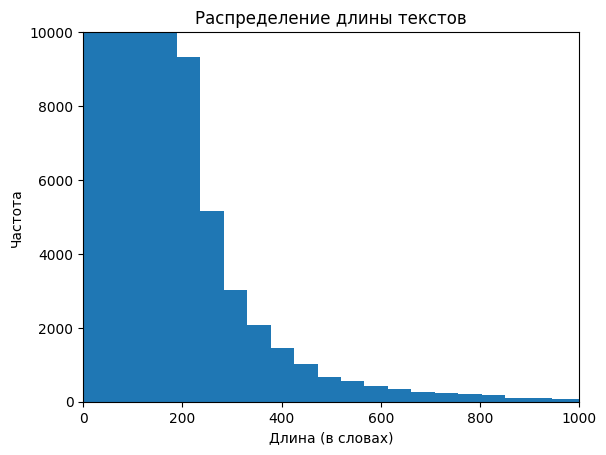

In [ ]:
# Примение к колонке с текстом функции предобработки
data_train["tokens"] = data_train["text"].apply(preprocess)

#  Длина текста
data_train["text_length"] = data_train["tokens"].apply(len)

# Статистика
print("Средняя длина текста:", data_train["text_length"].mean().round())
print("Медиана длины текста:", data_train["text_length"].median())
print("Максимальная длина текста:", data_train["text_length"].max())
print("Минимальная длина текста:", data_train["text_length"].min())
plt.hist(data_train["text_length"], bins=1000)
plt.xlim(0, 1000)  #ограничение осей для наглядности
plt.ylim(0, 10000)
plt.title("Распределение длины текстов")
plt.xlabel("Длина (в словах)")
plt.ylabel("Частота")
plt.show()


In [ ]:
# Количество уникальных слов в датасете
all_words = [word for tokens in data_train["tokens"] for word in tokens]
unique_words = set(all_words)
print("Уникальных слов:", len(unique_words))



Уникальных слов: 637270


In [ ]:
# Топ N самых частых слов
N = 20
word_freq = Counter(all_words)
top_words = word_freq.most_common(N)
print("Топ", N, "слов:", top_words)

Топ 20 слов: [('и', 753812), ('в', 752818), ('не', 443251), ('на', 401127), ('с', 266274), ('что', 250420), ('по', 156769), ('а', 145873), ('я', 143679), ('очень', 139823), ('но', 136840), ('это', 128531), ('все', 124673), ('за', 120052), ('к', 113646), ('как', 113096), ('у', 100095), ('для', 90354), ('так', 82071), ('от', 79274)]


In [ ]:
#Считаем самые частые биграмы
bigrams = ngrams(all_words, 2)
bigram_counts = Counter(bigrams)

top_bigrams = bigram_counts.most_common(10)
print(f"Топ биграммы: {top_bigrams}")

Топ биграммы: [(('и', 'не'), 26000), (('у', 'меня'), 19493), (('в', 'этом'), 18377), (('и', 'в'), 16013), (('у', 'нас'), 15043), (('в', 'номере'), 14813), (('то', 'что'), 14626), (('не', 'было'), 14018), (('я', 'не'), 12167), (('так', 'как'), 11741)]


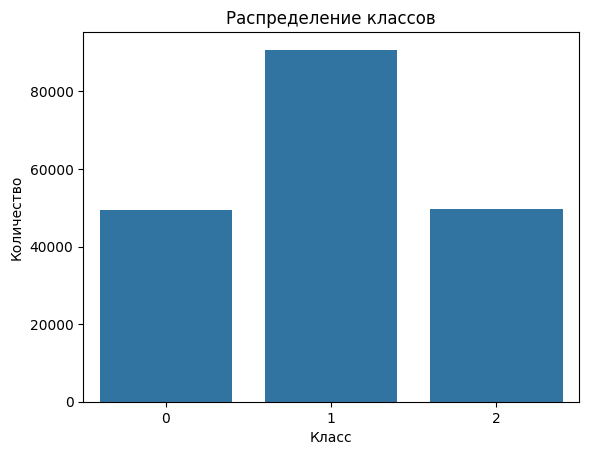

Баланс классов:
sentiment
1    0.477990
2    0.262245
0    0.259765
Name: proportion, dtype: float64


In [ ]:
# Считаем количество примеров каждого класса
class_counts = data_train["sentiment"]
sns.countplot(x=class_counts)
plt.title("Распределение классов")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.show()

# Проверяем баланс
print("Баланс классов:")
print(pd.Series(class_counts).value_counts(normalize=True))

Выбирается **BERTopic** для тематического моделирования, поскольку это мощный и удобный инструмент, предоставляющий полноценный пайплайн «из коробки». Он автоматически выполняет все ключевые этапы анализа:

1)Векторизацию текста

2)Снижение размерности векторного пространства

3)Кластеризацию текстов по смысловой близости

4)Выделение тем на основе наиболее репрезентативных слов в каждом кластере

Одним из главных преимуществ BERTopic является гибкость: в пайплайн можно легко подставлять свои модели на разных этапах. Это позволяет адаптировать инструмент под конкретные задачи и типы данных.

In [ ]:
%pip install bertopic -q

In [ ]:
from bertopic import BERTopic
topic_model = BERTopic(language="multilingual", verbose=True)
topics, probs = topic_model.fit_transform(data_train["text"])

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,84023,-1_на_не_отель_номер,"[на, не, отель, номер, что, по, за, от, есть, ...",[Создайте сайт Каждые полгода с мамой приезжае...
1,0,28064,0_ресторан_меню_кухня_ресторана,"[ресторан, меню, кухня, ресторана, интерьер, р...",[День рождения жены решили отметить в китайско...
2,1,7633,1_зуб_зубы_зуба_зубов,"[зуб, зубы, зуба, зубов, клинику, стоматологии...",[Будьте аккуратней Пришла я значит в поликлини...
3,2,5731,2_беременности_беременность_роды_рожала,"[беременности, беременность, роды, рожала, род...",[Не пугайтесь отзывов 10.04.04 г. в 67 роддоме...
4,3,5447,3_москвы_метро_отель_москве,"[москвы, метро, отель, москве, номера, номер, ...",[Отель расположен в достаточно тихом районе(у ...
...,...,...,...,...,...
813,812,10,812_нарушал_избирком_нарушении_оп,"[нарушал, избирком, нарушении, оп, платформы, ...","[Как еще сказать?Если Вы хотите утверждать, чт..."
814,813,10,813_козырева_шогеновой_марите_валерьевна,"[козырева, шогеновой, марите, валерьевна, сыну...",[Вылечили сыну сколиоз Хочу сказать слова благ...
815,814,10,814_московию_педиатр_педиатру_участковому,"[московию, педиатр, педиатру, участковому, лим...",[Выражаю благодарность участковому педиатру Вы...
816,815,10,815_благдарность_сдерживаясь_ублюдочный_сотруд...,"[благдарность, сдерживаясь, ублюдочный, сотруд...","[Конечно. В таком случае, очень рад за вашего ..."


In [ ]:
topic_model.visualize_topics()

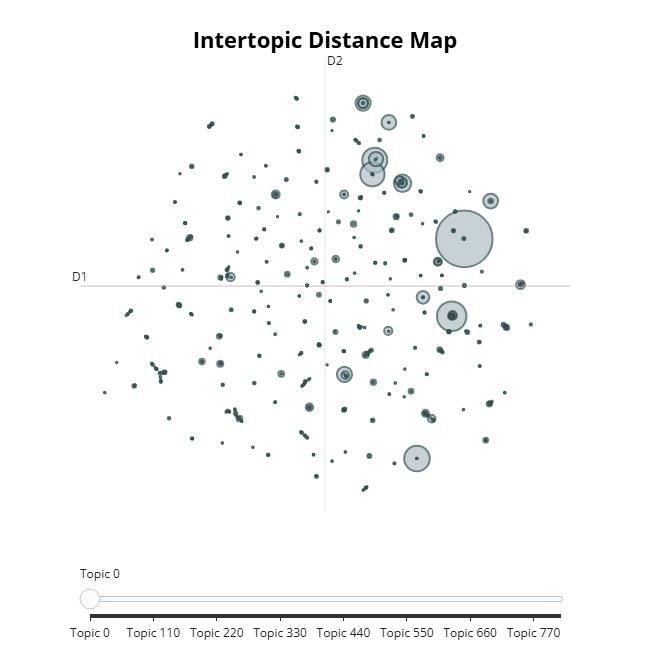

**Предложение по дальнейшему улучшнию тематического моделирования** - Для повышения качества можно реализовать автоматический подбор оптимальных компонентов пайплайна, а именно:

1) Выполнять перебор различных моделей векторизации текста (например, TF-IDF, Sentence-BERT, DistilBERT и тд.)

2) Тестировать разные алгоритмы кластеризации (такие как HDBSCAN, KMeans, Agglomerative Clustering и тд.)

3) Использовать GridSearch или аналогичные методы подбора гиперпараметров, чтобы найти наилучшие сочетания

После получения разных тематических моделей, их качество можно оценивать с помощью LLM.

Такой подход позволяет построить полностью автоматизированную систему выбора лучших параметров тематического моделирования.

# Часть 2. Обучение классификатора

In [ ]:
#Импорт и установка необходимых библиотек
%pip install datasets -q
from sklearn.model_selection import train_test_split
from datasets import Dataset
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score
import torch
import time


In [ ]:
#Разбиение данных на тренировочную и тестовую выборку, валидационная уже имеется
train_data, test_data = train_test_split(
    data_train,
    test_size=0.1,
    random_state=42,
    stratify=data_train["sentiment"]
)

In [ ]:
print("\nРаспределение классов:")
print("Train:", train_data["sentiment"].value_counts())
print("Valid:", val_data["sentiment"].value_counts())
print("Test:", test_data["sentiment"].value_counts())


Распределение классов:
Train: sentiment
1    81689
2    44818
0    44394
Name: count, dtype: int64
Valid: sentiment
1    10026
0     5560
2     5512
Name: count, dtype: int64
Test: sentiment
1    9077
2    4980
0    4933
Name: count, dtype: int64


In [ ]:
#Переименуем "sentiment" в "label" для удобства
train_data = train_data.rename(columns={"sentiment": "label"})
val_data = val_data.rename(columns={"sentiment": "label"})
test_data = test_data.rename(columns={"sentiment": "label"})

In [ ]:
train_dataset = Dataset.from_pandas(train_data.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_data.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_data.reset_index(drop=True))


В качестве основной модели выбирается **RuBERT**, дообученная на задачу сентимент-анализа. Эта модель основана на архитектуре трансформеров, что позволяет эффективно учитывать контекст и структуру языка при обработке текста как последовательности токенов.

Преимущество **RuBERT** в том, что она уже предварительно обучена на задаче определения тональности текста, поэтому её достаточно лишь дообучить на нашей выборке, чтобы адаптировать модель к специфике конкретных данных и тем самым повысить точность классификации.

Такой подход сочетает в себе силу готовой языковой модели и гибкость тонкой настройки под конкретную задачу.

In [ ]:
model_name = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

In [ ]:
#функция токенизации
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

In [ ]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

In [ ]:
#удаляем лишние колонки
columns_to_remove = ['Unnamed: 0',"text", ]
train_dataset = train_dataset.remove_columns([col for col in columns_to_remove if col in train_dataset.column_names])
test_dataset = test_dataset.remove_columns([col for col in columns_to_remove if col in test_dataset.column_names])
val_dataset = val_dataset.remove_columns([col for col in columns_to_remove if col in val_dataset.column_names])

Поскольку перед нами стоит задача многоклассовой классификации (три класса: положительный, нейтральный, негативный), основной метрикой качества модели выберем **F1-score**. Для более детального анализа результатов будем рассматривать усреднённые значения F1-macro и F1-micro.

В качестве функции потерь будет использоваться кросс-энтропия (**Cross-Entropy Loss**) — стандартный и эффективный выбор для многоклассовой классификации. Она позволяет модели корректно обучаться на основе вероятностного распределения по классам.

In [ ]:
#Функция для вычисления F1 метрик
def compute_metrics(pred):

    labels = pred.label_ids
    predictions = np.argmax(pred.predictions, axis=1)

    f1_micro = f1_score(labels, predictions, average='micro')
    f1_macro = f1_score(labels, predictions, average='macro')
    return {"f1_micro": f1_micro, "f1_macro": f1_macro}


In [ ]:
training_args = TrainingArguments(
    report_to="none",
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    eval_strategy="epoch",
    logging_dir="./logs",
    load_best_model_at_end=True,
    save_strategy="epoch",
    metric_for_best_model="f1_macro",
    seed=42,
)


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro
1,0.501000,0.495657,0.774576,0.761018
2,0.457300,0.478842,0.783155,0.773885
3,0.406000,0.484154,0.787752,0.776894


TrainOutput(global_step=32046, training_loss=0.4769653496965148, metrics={'train_runtime': 1047.205, 'train_samples_per_second': 489.592, 'train_steps_per_second': 30.601, 'total_flos': 945317755401984.0, 'train_loss': 0.4769653496965148, 'epoch': 3.0})

In [ ]:
test_results = trainer.evaluate(test_dataset)
print(test_results)

{'eval_loss': 0.48279517889022827, 'eval_f1_micro': 0.7889415481832543, 'eval_f1_macro': 0.7777086930620306, 'eval_runtime': 10.211, 'eval_samples_per_second': 1859.754, 'eval_steps_per_second': 58.172, 'epoch': 3.0}


In [ ]:
#сохраним модель
model.save_pretrained("./sentiment_model")
tokenizer.save_pretrained("./sentiment_model")

('./sentiment_model/tokenizer_config.json',
 './sentiment_model/special_tokens_map.json',
 './sentiment_model/vocab.txt',
 './sentiment_model/added_tokens.json',
 './sentiment_model/tokenizer.json')

In [ ]:
model_path = "./sentiment_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [ ]:
device_cpu = torch.device("cpu")
device_gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Переводим модель на CPU/GPU
model.to(device_cpu)
inputs_cpu = tokenizer(
    ["Пример текста для теста скорости"] * 100,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=256
).to(device_cpu)

# Замер на CPU
start_time = time.time()
with torch.no_grad():
    outputs_cpu = model(**inputs_cpu)
cpu_time = time.time() - start_time

# Замер на GPU
if torch.cuda.is_available():
    model.to(device_gpu)
    inputs_gpu = inputs_cpu.to(device_gpu)


    with torch.no_grad():
        _ = model(**inputs_gpu)


    start_time = time.time()
    with torch.no_grad():
        outputs_gpu = model(**inputs_gpu)
    gpu_time = time.time() - start_time
else:
    gpu_time = None

# Вывод результатов
print(f"CPU Time (100 samples): {cpu_time:.4f} sec")
if gpu_time:
    print(f"GPU Time (100 samples): {gpu_time:.4f} sec")
    print(f"GPU Speedup: {cpu_time / gpu_time:.2f}x")
else:
    print("GPU not available")

CPU Time (100 samples): 0.4287 sec
GPU Time (100 samples): 0.0185 sec
GPU Speedup: 23.21x


Для повышения качества модели можно применить дообучение только последних слоёв нейронной сети, вместо полной перенастройки всех параметров. Такой подход позволяет сохранить обобщающие способности предобученной модели и при этом эффективно адаптировать её к конкретной задаче. Дополнительно, качество можно улучшить за счёт расширения и разнообразия обучающего датасета, добавив больше примеров с различной лексикой, стилистикой и длиной текста.

Для ускорения инференса модели можно сконвертировать её в формат **ONNX**. Это позволит значительно снизить время выполнения модели за счёт аппаратных и программных оптимизаций.

# Часть 3. Оптимизация классификатора

Выберем **ONNX** как метод оптимизации, потому что он позволяет ускорить инференс на CPU без потери качества модели. Также можно квантовать модель, что значительно ускорит ее работу, однако из-за перевода весов в целые числа уменьшится точность.

In [ ]:
#Импорт и установка необходимых библиотек
%pip install onnx onnxruntime -q
import onnx
from onnxruntime.transformers import optimizer
import time
from onnxruntime import InferenceSession

In [ ]:
model_name = "./sentiment_model"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

# Пример входных данных (нужен для формирования ONNX-графа)
dummy_input = tokenizer(
    "Пример текста для конвертации",
    return_tensors="pt",
    truncation=True,
    max_length=256
)

# Конвертация в ONNX
torch.onnx.export(
    model,
    (dummy_input["input_ids"], dummy_input["attention_mask"]),
    "sentiment_model.onnx",
    input_names=["input_ids", "attention_mask"],
    output_names=["logits"],
    dynamic_axes={
        "input_ids": {0: "batch", 1: "sequence"},
        "attention_mask": {0: "batch", 1: "sequence"},
        "logits": {0: "batch"},
    },
    opset_version=15,
)

In [ ]:
# Оптимизация
optimized_model = optimizer.optimize_model(
    "sentiment_model.onnx",
    model_type='bert',
    num_heads=model.config.num_attention_heads,
    hidden_size=model.config.hidden_size
)
optimized_model.save_model_to_file("optimized_model.onnx")


In [ ]:
def evaluate_model(model, tokenizer, test_texts, test_labels):
    predictions = []
    times = []

    for text, label in zip(test_texts, test_labels):
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

        start_time = time.time()
        with torch.no_grad():
            outputs = model(**inputs)
        inference_time = time.time() - start_time

        pred = torch.argmax(outputs.logits).item()
        predictions.append(pred)
        times.append(inference_time)

    f1 = f1_score(test_labels, predictions, average='weighted')
    avg_time = np.mean(times)

    return f1, avg_time

In [ ]:
def evaluate_onnx_model(session, tokenizer, test_texts, test_labels):
    predictions = []
    times = []

    for text, label in zip(test_texts, test_labels):
        inputs = tokenizer(text, return_tensors="np", padding=True, truncation=True)


        onnx_inputs = {
            'input_ids': inputs['input_ids'].astype(np.int64),
            'attention_mask': inputs['attention_mask'].astype(np.int64)
        }

        start_time = time.time()
        onnx_outputs = session.run(None, onnx_inputs)
        inference_time = time.time() - start_time


        pred = np.argmax(onnx_outputs[0], axis=1)[0]
        predictions.append(pred)
        times.append(inference_time)


    f1 = f1_score(test_labels, predictions, average='weighted')
    avg_time = np.mean(times)

    return f1, avg_time

In [ ]:
# Загрузка тестовых данных
test_sample = test_data.sample(n=1000, random_state=42)
test_dataset_1 = Dataset.from_pandas(test_sample.reset_index(drop=True))
test_texts = test_dataset_1['text']
test_labels = test_dataset_1['label']

In [ ]:
orig_f1, orig_time = evaluate_model(model, tokenizer, test_texts, test_labels)

In [ ]:
onnx_session = InferenceSession("optimized_model.onnx")
onnx_f1, onnx_time = evaluate_onnx_model(onnx_session, tokenizer, test_texts, test_labels)

In [ ]:
# Создание таблицы
results = pd.DataFrame({
    "Model": ["Original", "ONNX"],
    "F1 Score": [orig_f1, onnx_f1],
    "Avg Inference Time (s)": [orig_time, onnx_time],
    "Speedup": [1.0, orig_time/onnx_time]
})

print(results)

      Model  F1 Score  Avg Inference Time (s)   Speedup
0  Original  0.781998                0.046557  1.000000
1      ONNX  0.781998                0.029704  1.567331


Как можно заметить выше, ONNX модель дала прирост в скорости и не упала в качестве. Если пробовать квантовать модель, можно получить прирост в скорости в 2-4 раза, но ухудшится точность.